## 画像の用意

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
import torchvision
from torchvision import transforms, datasets

dataset = datasets.CIFAR10(root='./', download=True)
dataset

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./
    Split: Train

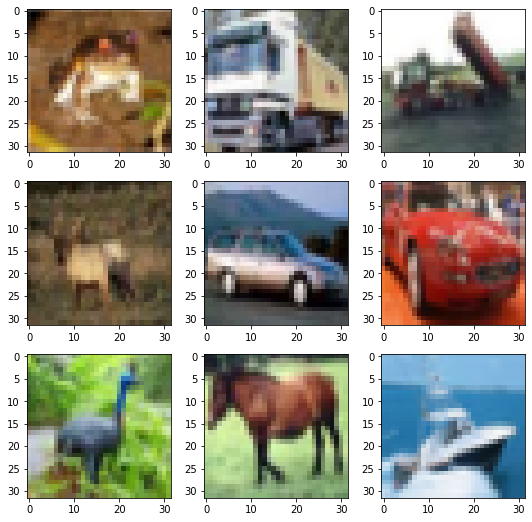

In [4]:
# 画像の表示
plt.figure(figsize=(9, 9))
for i in range(9):
    img = np.array(dataset[i][0])
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)

## データ拡張

In [5]:
def img_show(dataset, transform):
    plt.figure(figsize=(9, 9))
    for i in range(9):
        img = transform(dataset[i][0])
        img = np.array(img)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)

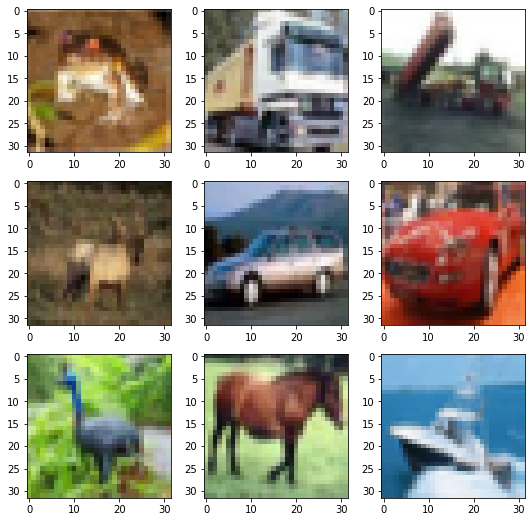

In [6]:
# 左右反転
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0)
])

img_show(dataset, transform)

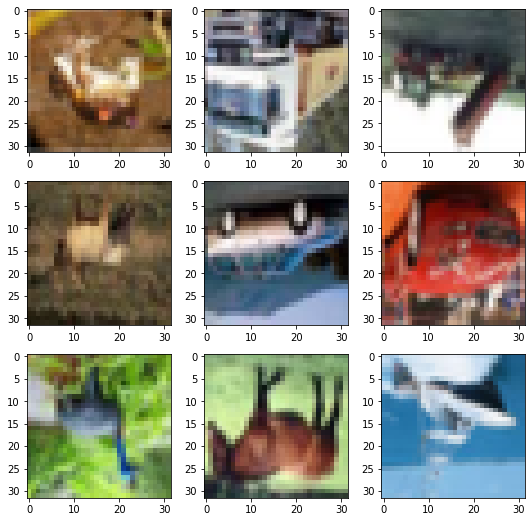

In [7]:
# 上下反転
transform = transforms.Compose([
    transforms.RandomVerticalFlip(p=1.0)
])

img_show(dataset, transform)

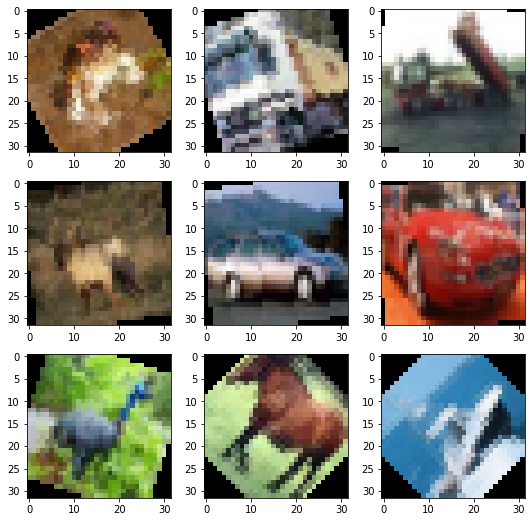

In [8]:
# 指定した角度内をランダムで回転
transform = transforms.Compose([
    transforms.RandomRotation(45)
])

img_show(dataset, transform)

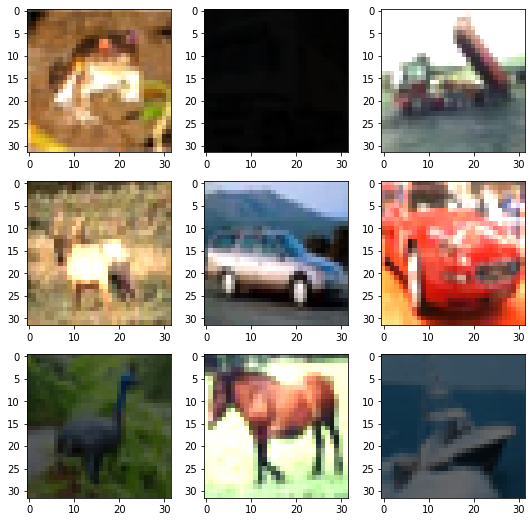

In [9]:
# ランダムに明るさを変更
transform = transforms.Compose([
    transforms.ColorJitter(brightness=1)
])

img_show(dataset, transform)

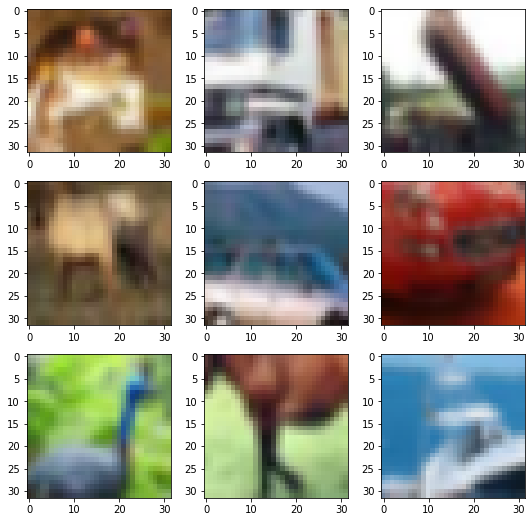

In [10]:
# ランダムに切り取り、リサイズでもとのサイズへ
transform = transforms.Compose([
    transforms.RandomCrop(20),
    transforms.Resize(32)
])

img_show(dataset, transform)

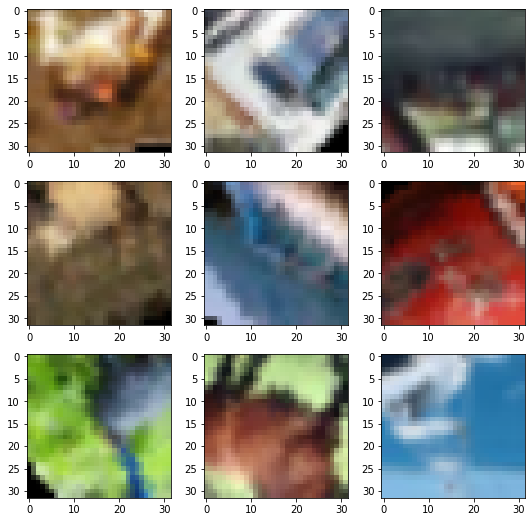

In [11]:
# transform をまとめる
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomVerticalFlip(p=1.0),
    transforms.RandomRotation(45),
    transforms.RandomCrop(20),
    transforms.Resize(32)
])

img_show(dataset, transform)

## その他のデータ拡張

### MixUp

2つの画像を合成して新しいサンプルを作成する手法です。 モデルの学習時にはラベル側も混ぜ合わせる必要があります。 この画像の合成の結果により、正則化の効果が生まれ、かつ、画像の中間も識別できるようになるため、精度が向上します。

In [12]:
import torch

In [13]:
transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = datasets.CIFAR10(root='./', download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=9, shuffle=True)

Files already downloaded and verified


In [14]:
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.
    batch_size = x.size()[0]
    index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [15]:
data, target = next(iter(dataloader))
mixed_data, target_a, target_b, lam = mixup_data(data, target, alpha=1.0)

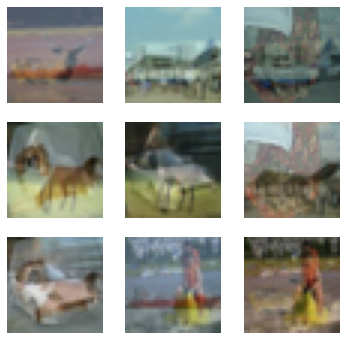

In [16]:
image_numb = 9
plt.figure(figsize=(6, 6))
for n in range(0, image_numb):
    ax = plt.subplot(image_numb / 3, 3, n + 1)
    plt.axis('off')
    plt.imshow(mixed_data[n].permute(1, 2, 0).detach().numpy())

### Random Erasing

In [17]:
def random_erasing(img, p=0.5, sl=0.02, sh=0.4, r1=0.3, r2=3.3):
    target_img = img.copy()

    H, W, _ = target_img.shape
    S = H * W

    while True:
        Se = np.random.uniform(sl, sh) * S 
        re = np.random.uniform(r1, r2) 

        He = int(np.sqrt(Se * re)) 
        We = int(np.sqrt(Se / re)) 

        xe = np.random.randint(0, W) 
        ye = np.random.randint(0, H) 

        if xe + We <= W and ye + He <= H:
            break

    mask = np.random.randint(0, 255, (He, We, 3)) 
    target_img[ye:ye + He, xe:xe + We, :] = mask

    return target_img

In [20]:
img = Image.open('sample.png').convert('RGB')

In [21]:
img = np.array(img)

In [22]:
target_img = random_erasing(img)

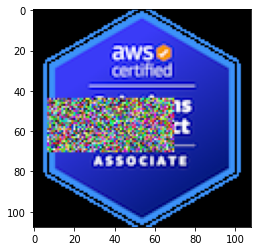

In [23]:
plt.imshow(target_img);